In [1]:
##读取图片
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#读取图像
img = cv.imread('./img/dlam.jpg', cv.COLOR_BGR2GRAY)
rgb_img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
#灰度化处理图
grayImage = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

In [3]:
##Roberts算子
Roberts_kernelx = np.array([[-1,0],[0,1]],dtype = int)
Roberts_kernely = np.array([[0,-1],[1,0]],dtype = int)
Roberts_x = cv.filter2D(grayImage,cv.CV_16S,Roberts_kernelx)
Roberts_y = cv.filter2D(grayImage,cv.CV_16S,Roberts_kernely)
Roberts_absX = cv.convertScaleAbs(Roberts_x)
Roberts_absY = cv.convertScaleAbs(Roberts_y)
Roberts = cv.addWeighted(Roberts_absX,0.5, Roberts_absY,0.5,0)

In [4]:
##Sobel算子
Sobel_kernelx = np.array([[1,2,1],[0,0,0],[-1,-2,-1]],dtype = int)
Sobel_kernely = np.array([[-1,0,1],[-2,0,2],[-1,0,1]],dtype = int)
Sobel_x = cv.filter2D(grayImage,cv.CV_16S,Sobel_kernelx)
Sobel_y = cv.filter2D(grayImage,cv.CV_16S,Sobel_kernely)
Sobel_absX = cv.convertScaleAbs(Sobel_x)
Sobel_absY = cv.convertScaleAbs(Sobel_y)
Sobel = cv.addWeighted(Sobel_absX,0.5,Sobel_absY,0.5,0)

In [5]:
##Prewitt算子
Prewitt_kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]],dtype = int)
Prewitt_kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]],dtype = int)
Prewitt_x = cv.filter2D(grayImage,cv.CV_16S,Prewitt_kernelx)
Prewitt_y = cv.filter2D(grayImage,cv.CV_16S,Prewitt_kernely)
Prewitt_absX = cv.convertScaleAbs(Prewitt_x)
Prewitt_absY = cv.convertScaleAbs(Prewitt_y)
Prewitt = cv.addWeighted(Prewitt_absX,0.5,Prewitt_absY,0.5,0)

In [6]:
##拉普拉斯算法
dst = cv.Laplacian(grayImage,cv.CV_16S,ksize = 3)
Laplacian = cv.convertScaleAbs(dst)

In [7]:
##LoG算法
gaussian_blur = cv.GaussianBlur(grayImage,(3,3),0)
LoG_dst = cv.Laplacian(gaussian_blur,cv.CV_16S,ksize = 3)
LoG = cv.convertScaleAbs(LoG_dst)

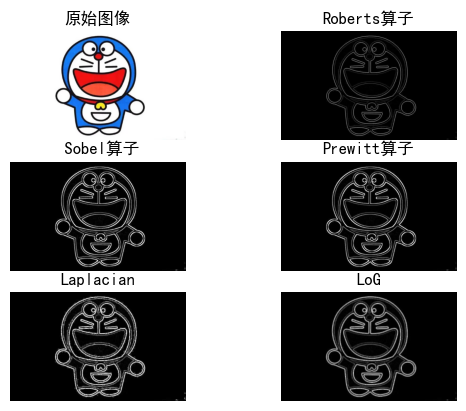

In [8]:
titles =['原始图像', 'Roberts算子',' Sobel算子','Prewitt算子','Laplacian','LoG']
images = [rgb_img,Roberts,Sobel,Prewitt,Laplacian,LoG]
#解决中文显示乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
for i in range(6):
    plt.subplot(3,2,i+1),plt.imshow(images[i],'gray')
    plt.axis("off")
    plt.title(titles[i])
#     plt.xticks(0),plt.yticks(0)

In [9]:
##手动设置阈值
the = 150
maxval = 255
_,dst = cv.threshold(grayImage,the,maxval,cv.THRESH_BINARY)

In [10]:
##Otsu阈值处理
otsuThe = 0
otsuThe,dst_Otsu = cv.threshold(grayImage,otsuThe,maxval,cv.THRESH_OTSU)

In [11]:
def adaptiveThresh(I,winSize,ratio=0.12):
    #第一步  对图像进行均值平滑
    I_mean = cv.boxFilter(I,cv.CV_32FC1,winSize)
    #第二步  原图像矩阵与平滑结果做差
    out = I - (1.0-ratio)*I_mean
    #第三步  当差值大子等于0时,输出值为255;反之输出为0
    out[out>=0] = 255
    out[out<0] = 0
    out = out.astype(np.uint8)
    return out
dst_adap = adaptiveThresh(grayImage,(35,35))

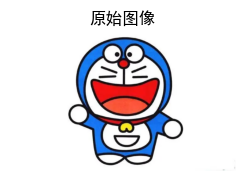

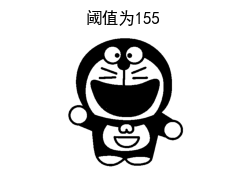

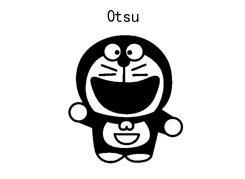

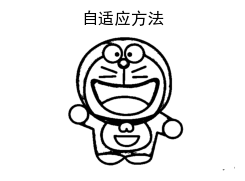

In [12]:
3plt.rcParams['font.sans-serif'] = ['SimHei']
titles=['原始图像','阈值为155','0tsu','自适应方法']
images = [rgb_img,dst,dst_Otsu,dst_adap]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.axis("off")
    plt.title(titles[i])
    plt.show()

In [13]:
##计算种子点和其领域的像素值之差
from collections import deque

In [32]:
def getGrayDiff(gray,current_seed,tmp_seed):
    return abs(int(gray[current_seed[0],current_seed[1]]) - int(gray[tmp_seed[0],tmp_seed[1]]))
               
#区域生长算法
def regional_growth(gray,seeds):
    #八领域
    connects = [(-1,-1),(0,-1),(1,-1),(1,0),\
               (1,1),(0,1),(-1,1),(-1,0)]
    seedMark = np.zeros((gray.shape))
    height,width = gray.shape
    threshold = 6
    seedque =deque()
    label = 255
    seedque.extend(seeds)
                    
    while seedque :
        #队列具有先进先出的性质，所以要左删
        current_seed = seedque.popleft()
        seedMark[current_seed[0],current_seed[1]] = label
        for i in range(8):
            tmpX = current_seed[0] + connects[i][0]
            tmpY = current_seed[1] + connects[i][1]
            #处理边界情况
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= width:
                continue
                
            grayDiff = getGrayDiff(gray,current_seed,(tmpX,tmpY))
            if grayDiff < threshold and seedMark[tmpX,tmpY] != label:
                seedque.append((tmpX,tmpY))
                seedMark[tmpX,tmpY] = label
    return seedMark

In [23]:
##交互函数
def Event_Mouse(event,x,y,flags,param):
    #左击鼠标
    if event == cv.EVENT_LBUTTONDOWN:
        #添加种子
        seeds.append((y,x))
        #画实心点
        cv.circle(img,center = (x,y),radius = 2,
                 color = (0,0,255),thickness = -1)

In [29]:
def Region_Grow(img):
    cv.namedWindow('img')
    cv.setMouseCallback('img',Event_Mouse)
    cv.imshow('img',img)
    
    while True:
        cv.imshow('img',img)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    cv.destroyAllWindows()
    
    CT = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    seedMark = np.uint8(regional_growth(CT,seeds))
    
    cv.imshow('seedMark',seedMark)
    cv.waitKey(0)
    
    plt.figure(figsize = (12,4))
    plt.subplot(131),plt.imshow(cv.cvtColor(CT,cv.COLOR_BGR2RGB))
    plt.axis('off'),plt.title(f'$input\_image$')
    plt.subplot(132),plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.axis('off'),plt.title(f'$seeds\_image$')
    plt.subplot(133),plt.imshow(seedMark,cmap = 'gray',vmin = 0,vmax = 255)
    plt.axis('off'),plt.title(f'$segmented\_image$')
    plt.tight_layout()
    plt.show()

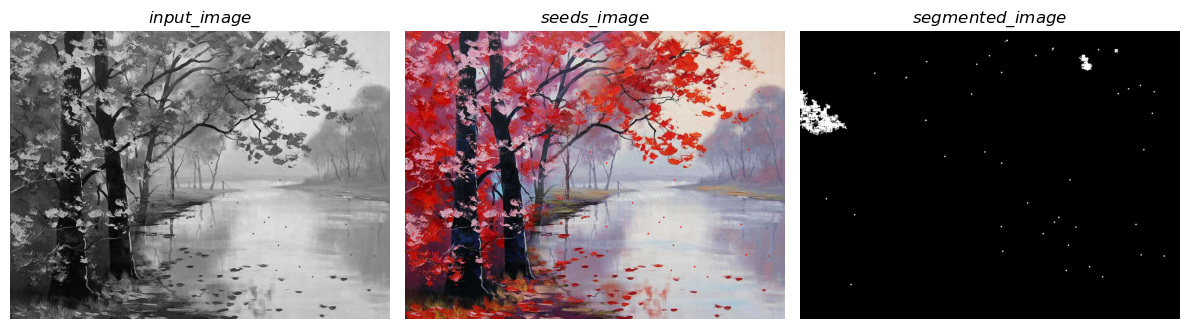

In [36]:
if __name__ == '__main__':
    img = cv.imread('./img/1.jpg')
    seeds = []
    Region_Grow(img)
    cv.destroyAllWindows()